## Generate figures [M132TS Downsampling Analysis]

In [1]:
%matplotlib inline

import os
import sys
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import logging
from operator import itemgetter

import scanpy as sc
import anndata

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

In [1]:
# load sample metadata
import yaml

with open('./downsampling_series_sample_metadata.yaml', 'r') as f:
    sample_meta_dict = yaml.safe_load(f)    

In [3]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'
long_tx_counts_root ='data/t-cell-vdj/long/quant/ds'
short_h5_path = 'output/t-cell-vdj-cite-seq/M132TS_immune.h5ad'
output_root = 'output/t-cell-vdj-cite-seq/ds'
fig_output_root = 'output/t-cell-vdj-cite-seq/ds/figures'
misc_output_root = 'output/t-cell-vdj-cite-seq/ds/misc'
output_prefix = 'M132TS_immune'

In [10]:
def plot_embedding_leiden(
        adata: sc.AnnData,
        embedding_key: str,
        leiden_key: str,
        markersize=2,
        alpha=0.75,
        xlabel='UMAP1',
        ylabel='UMAP2',
        label_kwargs=dict(bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)),
        x_offset=dict(),
        y_offset=dict(),
        fig=None,
        ax=None,
        show_labels=True,
        figsize=(3, 3)):
    
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    leiden_color_key = f'{leiden_key}_colors'
    assert leiden_color_key in set(adata.uns.keys())

    leiden_category_to_leiden_color_map = {
        leiden_category: leiden_color
        for leiden_color, leiden_category in zip(
            adata.uns[leiden_color_key],
            adata.obs[leiden_key].values.categories)}
    cell_color_list = list(
        map(leiden_category_to_leiden_color_map.get, adata.obs[leiden_key]))

    ax.scatter(
        adata.obsm[embedding_key][:, 0],
        adata.obsm[embedding_key][:, 1],
        color=cell_color_list,
        s=markersize,
        alpha=alpha)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if show_labels:
        for leiden_category in adata.obs[leiden_key].values.categories:
            try:
                dx = x_offset[leiden_category]
                dy = y_offset[leiden_category]
            except KeyError:
                dx = 0
                dy = 0
            x_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 0] + dx
            y_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 1] + dy
            x_c, y_c = np.mean(x_values), np.mean(y_values)
            ax.text(
                x_c, y_c, leiden_category,
                fontsize=8,
                ha='center',
                **label_kwargs)

In [11]:
def load_txt_data(sample_key: str, suffix: str) -> float:
    output_prefix_full = f'{output_prefix}_{sample_key}'
    with open(os.path.join(repo_root, misc_output_root, f'{output_prefix_full}_{suffix}.txt'), 'r') as f:
        for line in f:
            return float(line.strip())
        
def load_adata(sample_key: str, suffix: str) -> sc.AnnData:
    output_prefix_full = f'{output_prefix}_{sample_key}'
    return sc.read(os.path.join(repo_root, output_root, f'{output_prefix_full}_{suffix}.h5ad'))

def load_df(sample_key: str, suffix: str) -> pd.DataFrame:
    output_prefix_full = f'{output_prefix}_{sample_key}'
    return pd.read_csv(os.path.join(repo_root, output_root, f'{output_prefix_full}_{suffix}.csv'), index_col=0)

In [12]:
from collections import defaultdict

sample_key_list = [
    'gencode_1m',
    'gencode_isoseq',
    'gencode_5m',
    'gencode_10m',
    'gencode_20m',
    'gencode_30m',
    'gencode_masseq',
    'gencode_st2_ds_1m',
    'gencode_st2_ds_isoseq',
    'gencode_st2_ds_5m',
    'gencode_st2_ds_10m',
    'gencode_st2_ds_20m',
    'gencode_st2_ds_30m',
    'gencode_st2_ds_masseq',
    'gencode_st2_full_1m',
    'gencode_st2_full_isoseq',
    'gencode_st2_full_5m',
    'gencode_st2_full_10m',
    'gencode_st2_full_20m',
    'gencode_st2_full_30m',
    'gencode_st2_full_masseq',
]

sample_label_list = [
    'GENCODE (1M)',
    'GENCODE (Iso-Seq)',
    'GENCODE (5M)',
    'GENCODE (10M)',
    'GENCODE (20M)',
    'GENCODE (30M)',
    'GENCODE (MAS-seq)',
    'GENCODE + ST2 (1M)',
    'GENCODE + ST2 (Iso-Seq)',
    'GENCODE + ST2 (5M)',
    'GENCODE + ST2 (10M)',
    'GENCODE + ST2 (20M)',
    'GENCODE + ST2 (30M)',
    'GENCODE + ST2 (MAS-seq)',
    'GENCODE + ST2* (1M)',
    'GENCODE + ST2* (Iso-Seq)',
    'GENCODE + ST2* (5M)',
    'GENCODE + ST2* (10M)',
    'GENCODE + ST2* (20M)',
    'GENCODE + ST2* (30M)',
    'GENCODE + ST2* (MAS-seq)',
]

sampled_n_reads_list = [
    1.,
    1.604248,
    5.,
    10.,
    20.,
    30.,
    33.022383,
    1.,
    1.604248,
    5.,
    10.,
    20.,
    30.,
    33.022383,
    1.,
    1.604248,
    5.,
    10.,
    20.,
    30.,
    33.022383,
]

loaded_sample_info = defaultdict(dict)

for sample_key, sample_label, sampled_n_reads in zip(sample_key_list, sample_label_list, sampled_n_reads_list):
    
    log_info(f'Loading {sample_key} ...')
    
    loaded_sample_info[sample_key]['label'] = sample_label
    loaded_sample_info[sample_key]['n_reads'] = sampled_n_reads
    loaded_sample_info[sample_key]['n_umi_final'] = load_txt_data(sample_key, 'n_umi_final')
    loaded_sample_info[sample_key]['adj_rand_score'] = load_txt_data(sample_key, 'adj_rand_score')
    
    loaded_sample_info[sample_key]['adata'] = load_adata(sample_key, 'final_long_raw')
    del loaded_sample_info[sample_key]['adata'].X

    global_ds_df = load_df(sample_key, 'global_ds')
    group_resolved_ds_de_df = load_df(sample_key, 'group_resolved_ds_de')
    
    loaded_sample_info[sample_key]['global_ds_df'] = global_ds_df
    loaded_sample_info[sample_key]['group_resolved_ds_de_df'] = group_resolved_ds_de_df
    
    loaded_sample_info[sample_key]['n_ds_genes'] = np.sum(global_ds_df['ds_pval_global_adj'].values < 0.05)

Loading gencode_1m ...
Loading gencode_isoseq ...
Loading gencode_5m ...
Loading gencode_10m ...
Loading gencode_20m ...
Loading gencode_30m ...
Loading gencode_masseq ...
Loading gencode_st2_ds_1m ...
Loading gencode_st2_ds_isoseq ...
Loading gencode_st2_ds_5m ...
Loading gencode_st2_ds_10m ...
Loading gencode_st2_ds_20m ...
Loading gencode_st2_ds_30m ...
Loading gencode_st2_ds_masseq ...
Loading gencode_st2_full_1m ...
Loading gencode_st2_full_isoseq ...
Loading gencode_st2_full_5m ...
Loading gencode_st2_full_10m ...
Loading gencode_st2_full_20m ...
Loading gencode_st2_full_30m ...
Loading gencode_st2_full_masseq ...


In [21]:
def plot_umap_evolution(plot_sample_key_list):
    
    n = len(plot_sample_key_list)
    
    fig, axs = plt.subplots(
        ncols=n,
        figsize=(3 * n, 3))

    for sample_key, ax in zip(plot_sample_key_list, axs):
        try:

            plot_embedding_leiden(
                adata=loaded_sample_info[sample_key]['adata'],
                embedding_key='X_umap_SCT_long',
                leiden_key='mehrtash_leiden',
                fig=fig,
                ax=ax)
            
            ax.text(
                0.05,
                0.90,
                f'ARI: {loaded_sample_info[sample_key]["adj_rand_score"]:.2f}',
                transform=ax.transAxes)        
        
        except:
            pass
        
        ax.axis('square')
        ax.set_title(loaded_sample_info[sample_key]['label'])
        ax.set_xticks([])
        ax.set_yticks([])
        
    return fig

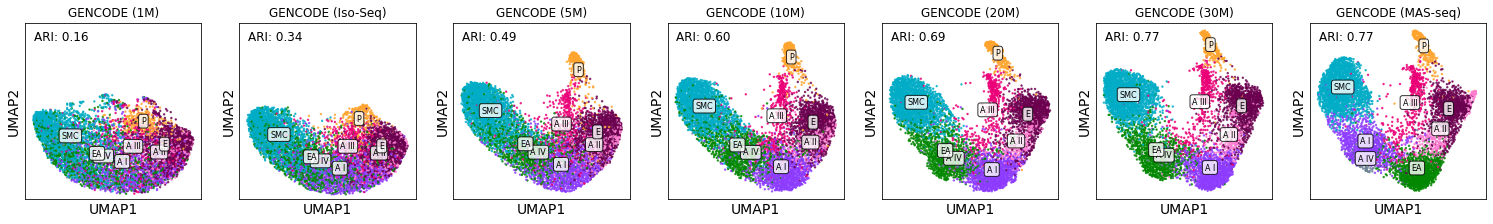

In [22]:
fig = plot_umap_evolution([
    'gencode_1m',
    'gencode_isoseq',
    'gencode_5m',
    'gencode_10m',
    'gencode_20m',
    'gencode_30m',
    'gencode_masseq',
])

fig.tight_layout()
fig.savefig('./M132TS__UMAP__evolution__gencode.pdf')

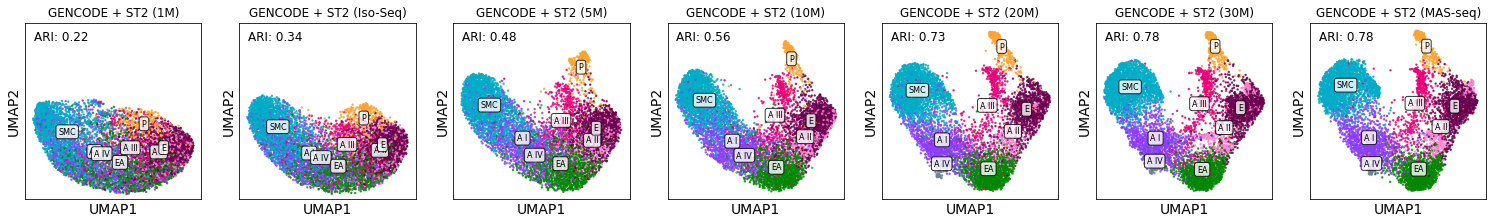

In [23]:
fig = plot_umap_evolution([
    'gencode_st2_ds_1m',
    'gencode_st2_ds_isoseq',
    'gencode_st2_ds_5m',
    'gencode_st2_ds_10m',
    'gencode_st2_ds_20m',
    'gencode_st2_ds_30m',
    'gencode_st2_ds_masseq',
])

fig.tight_layout()
fig.savefig('./M132TS__UMAP__evolution__gencode_st2_ds.pdf')

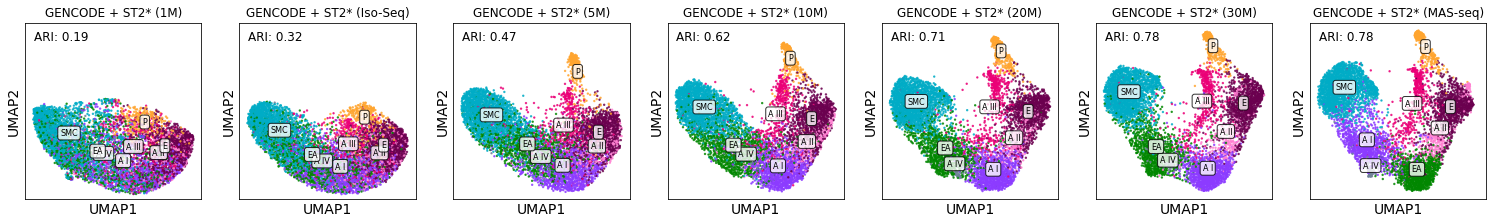

In [24]:
fig = plot_umap_evolution([
    'gencode_st2_full_1m',
    'gencode_st2_full_isoseq',
    'gencode_st2_full_5m',
    'gencode_st2_full_10m',
    'gencode_st2_full_20m',
    'gencode_st2_full_30m',
    'gencode_st2_full_masseq',
])

fig.tight_layout()
fig.savefig('./M132TS__UMAP__evolution__gencode_st2_full.pdf')

In [81]:
def plot_series(
        x_key: str,
        y_key: str,
        plot_sample_key_list,
        x_scale: float = 1.,
        annotate: bool = True,
        annotate_sample_key_list = None,
        x_offset_rel: float = 0.03,
        y_offset_rel: float = -0.02,
        x_label: str = 'Number of UMIs (x 1M)',
        y_label: str = 'Adjusted Rand Index',
        figsize=(5, 4),
        fig=None,
        ax=None,
        **kwargs):

    if fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    x = list(loaded_sample_info[sample_key][x_key] / x_scale for sample_key in plot_sample_key_list)
    y = list(loaded_sample_info[sample_key][y_key] for sample_key in plot_sample_key_list)

    ax.plot(x, y, marker='o', **kwargs)

    if annotate:    
        
        if annotate_sample_key_list is None:
            annotate_sample_key_list = plot_sample_key_list
        
        x_offset = x_offset_rel * np.max(x)
        y_offset = y_offset_rel * np.max(y)
        
        for i, sample_key in enumerate(annotate_sample_key_list):
            xx = loaded_sample_info[sample_key][x_key]  / x_scale
            yy = loaded_sample_info[sample_key][y_key] 
            label = loaded_sample_info[sample_key]["label"]
            s = 2 * (i % 2) - 1
            ax.text(xx + x_offset, yy + s * y_offset, label, fontsize=8)
        
    return fig, ax

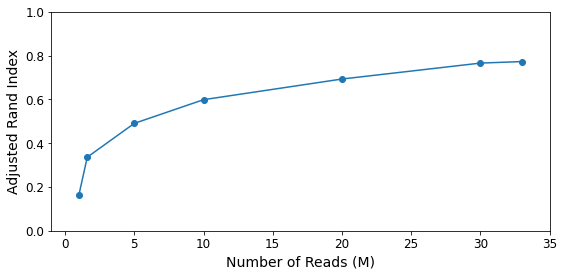

In [98]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="adj_rand_score",
    x_label='Number of Reads (M)',
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_1m',
        'gencode_isoseq',
        'gencode_5m',
        'gencode_10m',
        'gencode_20m',
        'gencode_30m',
        'gencode_masseq'],
    annotate=False)

ax.set_ylim((0, 1))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__ARI__gencode.pdf')

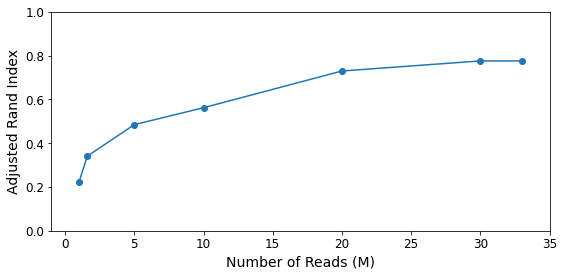

In [99]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="adj_rand_score",
    x_label='Number of Reads (M)',
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_ds_1m',
        'gencode_st2_ds_isoseq',
        'gencode_st2_ds_5m',
        'gencode_st2_ds_10m',
        'gencode_st2_ds_20m',
        'gencode_st2_ds_30m',
        'gencode_st2_ds_masseq'],
    annotate=False)


ax.set_ylim((0, 1))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__ARI__gencode_st2_ds.pdf')

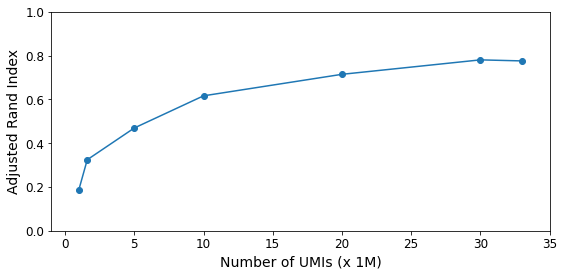

In [100]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="adj_rand_score",
    x_offset_rel=-0.17,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_full_1m',
        'gencode_st2_full_isoseq',
        'gencode_st2_full_5m',
        'gencode_st2_full_10m',
        'gencode_st2_full_20m',
        'gencode_st2_full_30m',
        'gencode_st2_full_masseq'],
    annotate=False)


ax.set_ylim((0, 1))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__ARI__gencode_st2_full.pdf')

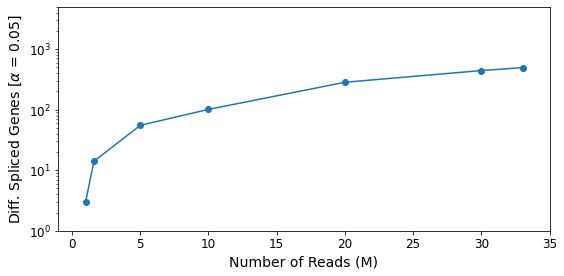

In [71]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_1m',
        'gencode_isoseq',
        'gencode_5m',
        'gencode_10m',
        'gencode_20m',
        'gencode_30m',
        'gencode_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False)

ax.set_yscale('log')
ax.set_ylim((1, 5000))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__DS__gencode__log.pdf')

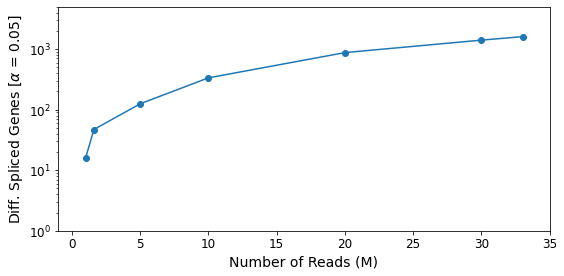

In [72]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_ds_1m',
        'gencode_st2_ds_isoseq',
        'gencode_st2_ds_5m',
        'gencode_st2_ds_10m',
        'gencode_st2_ds_20m',
        'gencode_st2_ds_30m',
        'gencode_st2_ds_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False)

ax.set_yscale('log')
ax.set_ylim((1, 5000))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__DS__gencode_st2_ds__log.pdf')

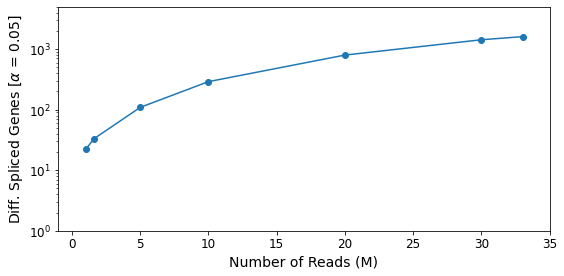

In [73]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_full_1m',
        'gencode_st2_full_isoseq',
        'gencode_st2_full_5m',
        'gencode_st2_full_10m',
        'gencode_st2_full_20m',
        'gencode_st2_full_30m',
        'gencode_st2_full_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False)

ax.set_yscale('log')
ax.set_ylim((1, 5000))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__DS__gencode_st2_full__log.pdf')

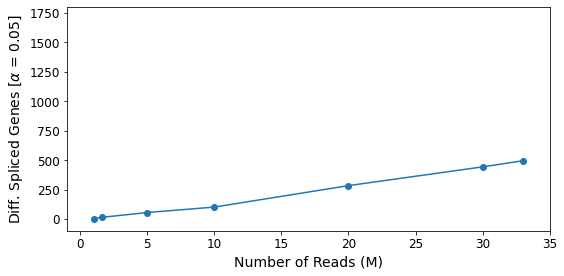

In [78]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_1m',
        'gencode_isoseq',
        'gencode_5m',
        'gencode_10m',
        'gencode_20m',
        'gencode_30m',
        'gencode_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False)

# ax.set_yscale('log')
ax.set_ylim((-100, 1800))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__DS__gencode__lin.pdf')

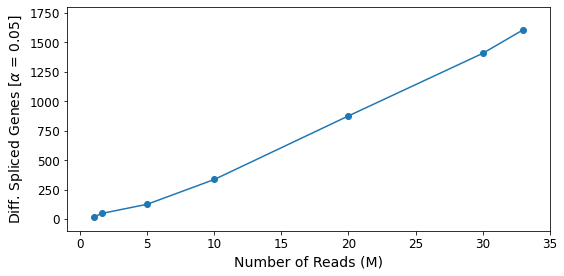

In [79]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_ds_1m',
        'gencode_st2_ds_isoseq',
        'gencode_st2_ds_5m',
        'gencode_st2_ds_10m',
        'gencode_st2_ds_20m',
        'gencode_st2_ds_30m',
        'gencode_st2_ds_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False)

# ax.set_yscale('log')
ax.set_ylim((-100, 1800))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__DS__gencode_st2_ds__lin.pdf')

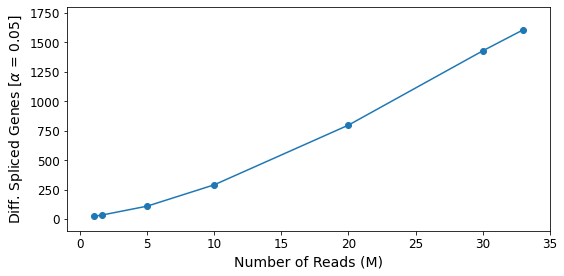

In [80]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_full_1m',
        'gencode_st2_full_isoseq',
        'gencode_st2_full_5m',
        'gencode_st2_full_10m',
        'gencode_st2_full_20m',
        'gencode_st2_full_30m',
        'gencode_st2_full_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False)

# ax.set_yscale('log')
ax.set_ylim((-100, 1800))
ax.set_xlim((-1, 35))

fig.tight_layout()
fig.savefig('./M132TS__DS__gencode_st2_full__lin.pdf')

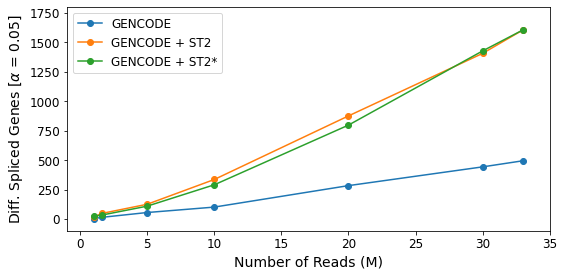

In [97]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_1m',
        'gencode_isoseq',
        'gencode_5m',
        'gencode_10m',
        'gencode_20m',
        'gencode_30m',
        'gencode_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False,
    label='GENCODE')

fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_ds_1m',
        'gencode_st2_ds_isoseq',
        'gencode_st2_ds_5m',
        'gencode_st2_ds_10m',
        'gencode_st2_ds_20m',
        'gencode_st2_ds_30m',
        'gencode_st2_ds_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False,
    label='GENCODE + ST2',
    fig=fig,
    ax=ax
)

fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_full_1m',
        'gencode_st2_full_isoseq',
        'gencode_st2_full_5m',
        'gencode_st2_full_10m',
        'gencode_st2_full_20m',
        'gencode_st2_full_30m',
        'gencode_st2_full_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False,
    label='GENCODE + ST2*',
    fig=fig,
    ax=ax
)

ax.legend()
ax.set_ylim((-100, 1800))
ax.set_xlim((-1, 35))
ax.legend()

fig.tight_layout()
fig.savefig('./M132TS__DS__combined__lin.pdf')

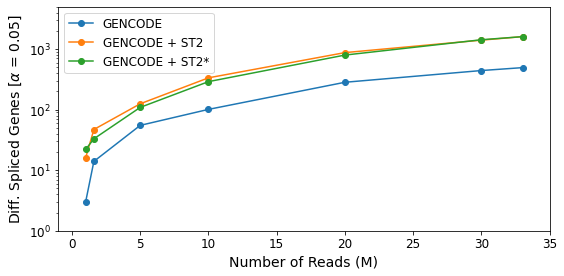

In [96]:
fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_1m',
        'gencode_isoseq',
        'gencode_5m',
        'gencode_10m',
        'gencode_20m',
        'gencode_30m',
        'gencode_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False,
    label='GENCODE')

fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_ds_1m',
        'gencode_st2_ds_isoseq',
        'gencode_st2_ds_5m',
        'gencode_st2_ds_10m',
        'gencode_st2_ds_20m',
        'gencode_st2_ds_30m',
        'gencode_st2_ds_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False,
    label='GENCODE + ST2',
    fig=fig,
    ax=ax
)

fig, ax = plot_series(
    x_key="n_reads",
    y_key="n_ds_genes",
    x_offset_rel=-0.1,
    y_offset_rel=0.08,
    figsize=(8, 4),
    plot_sample_key_list=[
        'gencode_st2_full_1m',
        'gencode_st2_full_isoseq',
        'gencode_st2_full_5m',
        'gencode_st2_full_10m',
        'gencode_st2_full_20m',
        'gencode_st2_full_30m',
        'gencode_st2_full_masseq',
    ],
    x_label='Number of Reads (M)',
    y_label=r'Diff. Spliced Genes [$\alpha$ = 0.05]',
    annotate=False,
    label='GENCODE + ST2*',
    fig=fig,
    ax=ax
)

ax.set_yscale('log')
ax.set_ylim((1, 5000))
ax.set_xlim((-1, 35))
ax.legend()

fig.tight_layout()

fig.savefig('./M132TS__DS__combined__log.pdf')

In [102]:
sample_df = pd.DataFrame({
    'sample_key': sample_key_list,
    'sample_labels': sample_label_list,
    'n_reads': sampled_n_reads_list,
    'adj_rand_score': list(loaded_sample_info[sample_key]['adj_rand_score'] for sample_key in sample_key_list),
    'n_ds_genes': list(loaded_sample_info[sample_key]['n_ds_genes'] for sample_key in sample_key_list)
})

In [103]:
sample_df.to_csv('./M132TS__clustering_and_diff_splicing_downsampling_series.csv')

In [104]:
sample_df

,sample_key,sample_labels,n_reads,adj_rand_score,n_ds_genes
0,gencode_1m,GENCODE (1M),1.000000,0.163329,3
1,gencode_isoseq,GENCODE (Iso-Seq),1.604248,0.336070,14
2,gencode_5m,GENCODE (5M),5.000000,0.490276,55
3,gencode_10m,GENCODE (10M),10.000000,0.598465,101
4,gencode_20m,GENCODE (20M),20.000000,0.692766,283
5,gencode_30m,GENCODE (30M),30.000000,0.765505,442
6,gencode_masseq,GENCODE (MAS-seq),33.022383,0.772533,494
7,gencode_st2_ds_1m,GENCODE + ST2 (1M),1.000000,0.220618,16
8,gencode_st2_ds_isoseq,GENCODE + ST2 (Iso-Seq),1.604248,0.340529,47
9,gencode_st2_ds_5m,GENCODE + ST2 (5M),5.000000,0.484474,125


## Venn diagrams

In [98]:
import matplotlib_venn as mplv
import colorcet as cc

In [14]:
group_resolved_ds_de_df = loaded_sample_info['gencode_st2_full_masseq']['group_resolved_ds_de_df']

In [260]:
leiden_idx = 7
de_gene_set = set(group_resolved_ds_de_df.index[group_resolved_ds_de_df[f'de_pval_adj_{leiden_idx}'] < 0.05])
ds_gene_set = set(group_resolved_ds_de_df.index[group_resolved_ds_de_df[f'ds_pval_adj_{leiden_idx}'] < 0.05])

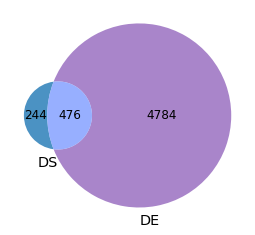

In [261]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mplv.venn2(
    (ds_gene_set, de_gene_set),
    set_labels=('DS', 'DE'),
    alpha=0.8,
    set_colors=(colors[0], colors[4])
)

In [262]:
# de, ds
n_11 = len(de_gene_set.intersection(ds_gene_set))
n_10 = len(de_gene_set.difference(ds_gene_set))
n_01 = len(ds_gene_set.difference(de_gene_set))
n_00 = len(group_resolved_ds_de_df) - n_11 - n_10 - n_01

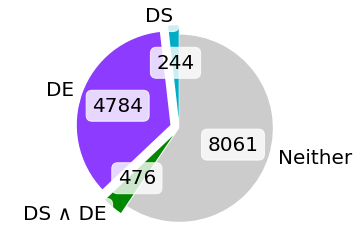

In [263]:
labels = 'DS', 'DE', 'DS ∧ DE', 'Neither'
sizes = [n_01, n_10, n_11, n_00]
total = sum(sizes)
explode = (0.1, 0.1, 0.1, 0)
colors = [cc.glasbey[3], cc.glasbey[1], cc.glasbey[2], (0.8, 0.8, 0.8)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors,
        textprops=dict(bbox=dict(boxstyle='round', edgecolor='white', facecolor='white', alpha=0.8), fontsize=20),
        autopct=lambda p: '{:.0f}'.format(p * total / 100),
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.tight_layout()
plt.savefig(f'./output/M132TS__ds_de_pie__{leiden_idx}_vs_rest.pdf', bbox_inches='tight')

## Downsampling props per cluster

In [273]:
ds_series_labels = [
    'gencode_st2_ds_1m',
    'gencode_st2_ds_isoseq',
    'gencode_st2_ds_5m',
    'gencode_st2_ds_10m',
    'gencode_st2_ds_20m',
    'gencode_st2_ds_30m',
    'gencode_st2_ds_masseq']

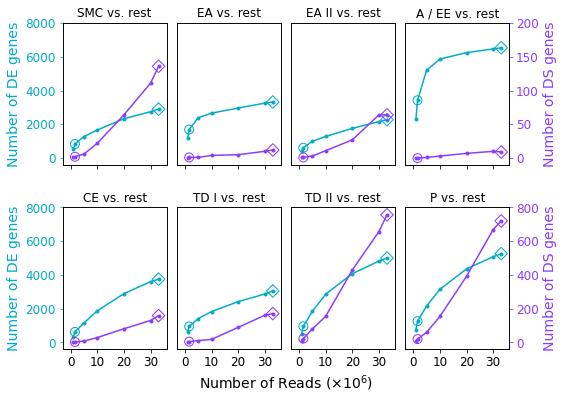

In [342]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 6), sharex=True)
labels = [
    'SMC vs. rest',
    'EA vs. rest',
    'EA II vs. rest',
    'A / EE vs. rest',
    'CE vs. rest',
    'TD I vs. rest',
    'TD II vs. rest',
    'P vs. rest',
]

isoseq_index = 1
masseq_index = 6

for leiden_idx, ax, label in zip(range(8), axs.flatten(), labels):
    
    n_de_series = []
    n_ds_series = []
    n_reads_series = []
    for sample_key in ds_series_labels:
        df = loaded_sample_info[sample_key]['group_resolved_ds_de_df']
        n_de = len(df.index[df[f'de_pval_adj_{leiden_idx}'] < 0.05])
        n_ds = len(df.index[df[f'ds_pval_adj_{leiden_idx}'] < 0.05])
        n_reads = loaded_sample_info[sample_key]['n_reads']
        n_de_series.append(n_de)
        n_ds_series.append(n_ds)
        n_reads_series.append(n_reads)
    
    ax.plot(n_reads_series, n_de_series, color=cc.glasbey[3], marker='.')
    ax.scatter(
        n_reads_series[isoseq_index],
        n_de_series[isoseq_index],
        color=cc.glasbey[3], marker='o', s=80, facecolors='none',)
    ax.scatter(
        n_reads_series[masseq_index],
        n_de_series[masseq_index],
        color=cc.glasbey[3], marker='D', s=80, facecolors='none',)

    ax2 = ax.twinx()

    ax2.plot(n_reads_series, n_ds_series, color=cc.glasbey[1], marker='.')
    ax2.scatter(
        n_reads_series[isoseq_index],
        n_ds_series[isoseq_index],
        color=cc.glasbey[1], marker='o', s=80, facecolors='none',)
    ax2.scatter(
        n_reads_series[masseq_index],
        n_ds_series[masseq_index],
        color=cc.glasbey[1], marker='D', s=80, facecolors='none',)

    ax.yaxis.label.set_color(cc.glasbey[3])
    ax.tick_params(axis='y', colors=cc.glasbey[3])

    ax2.yaxis.label.set_color(cc.glasbey[1])
    ax2.tick_params(axis='y', colors=cc.glasbey[1])

    ax.set_xlim((-3, 36))
    ax.set_ylim((-400, 8000))

    ax2.set_xlim((-3, 36))
    ax2.set_ylim((-40, 800))
    
    ax.set_title(label)
    
    if leiden_idx == 0:
        ax.set_xticks([])
        ax2.set_yticks([])
        ax2.set_ylim((-10, 200))
        ax.set_ylabel('Number of DE genes')
    if leiden_idx == 1:
        ax.set_xticks([])
        ax.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_ylim((-10, 200))
    if leiden_idx == 2:
        ax.set_xticks([])
        ax.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_ylim((-10, 200))
    elif leiden_idx == 3:
        ax.set_yticks([])
        ax.set_xticks([])
        ax2.set_ylim((-10, 200))
        ax2.set_ylabel('Number of DS genes')
    elif leiden_idx == 4:
        ax.set_xticks((0, 10, 20, 30))
        ax2.set_yticks([])
        ax.set_ylabel('Number of DE genes')
    elif leiden_idx == 5:
        ax.set_xticks((0, 10, 20, 30))
        ax.set_yticks([])
        ax2.set_yticks([])
    elif leiden_idx == 6:
        ax.set_xticks((0, 10, 20, 30))
        ax.set_yticks([])
        ax2.set_yticks([])
    elif leiden_idx == 7:
        ax.set_xticks((0, 10, 20, 30))
        ax.set_yticks([])
        ax2.set_ylabel('Number of DS genes')
    
plt.subplots_adjust(wspace=0.1, hspace=0.3)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Number of Reads ($\\times 10^6$)")

# fig.tight_layout()
plt.savefig('./output/M132TS__DS_DE__per_cluster__downsampling.pdf', bbox_inches='tight')